First 5 rows:
    gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       1              0        1           0     1.0             0   
1       0              0        0           0    34.0             1   
2       0              0        0           0     2.0             1   
3       0              0        0           0    45.0             0   
4       1              0        0           0     2.0             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   TechSupport_Yes  StreamingTV_No internet service  StreamingTV_Yes  \
0            False                            False            False   
1            False     

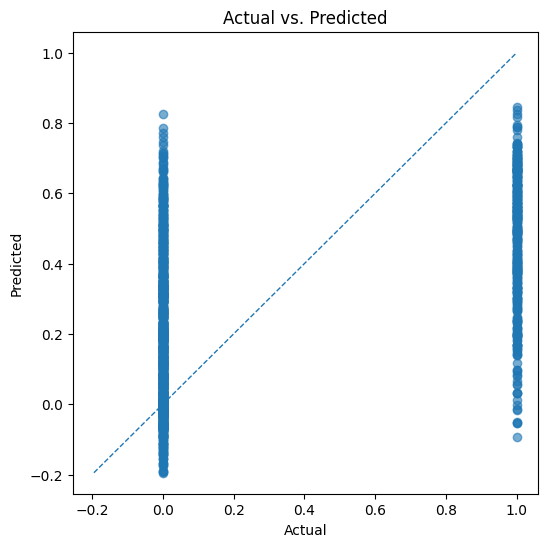

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Load the data
csv_path = "/Users/limengfeiyang/CMOR438-final-project/data/telco_churn_clean.csv"
df = pd.read_csv(csv_path)


# Peek at the first few rows and column names + dtypes
print("First 5 rows:\n", df.head(), "\n")
print("Column names and dtypes:\n", df.dtypes, "\n")



# Identify and encode categoricals
target_col = "Churn"  

# List all object or category columns
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns detected:", cat_cols)

# Remove the target from the list so we don’t one-hot the label itself
if target_col in cat_cols:
    cat_cols.remove(target_col)

print("Will one-hot encode:", cat_cols, "\n")

# One-hot encode (drop_first=True to avoid collinearity)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("After encoding, new columns are:")
print(df_encoded.columns.tolist(), "\n")



# Prepare X and y arrays

# Inspect
print("Target dtype:", df_encoded[target_col].dtype)
print("Unique values:", df_encoded[target_col].unique())

# Build y correctly
if pd.api.types.is_numeric_dtype(df_encoded[target_col]):
    # already numeric 0/1
    y = df_encoded[target_col].astype(float).values
else:
    y = df_encoded[target_col].map({"Yes":1, "No":0}).astype(float).values

# Build X as before
X = df_encoded.drop(columns=[target_col]).astype(float).values


# Split into train and test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training on {X_train.shape[0]} rows; testing on {X_test.shape[0]} rows.\n")



# Define LinearRegression class
import numpy as np

class LinearRegression:
    """OLS Linear Regression via pseudo-inverse (no singular-matrix errors)."""

    def __init__(self, fit_intercept: bool = True):
        self.fit_intercept = fit_intercept
        self.coef_: np.ndarray = None

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        """Prepend column of ones for intercept."""
        return np.hstack([np.ones((X.shape[0],1)), X])

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit model to data using Moore-Penrose pseudo-inverse:
            θ = pinv(X) @ y
        """
        if self.fit_intercept:
            X = self._add_intercept(X)

        # Use pinv instead of inv to avoid singular matrix errors
        self.coef_ = np.linalg.pinv(X) @ y

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            X = self._add_intercept(X)
        return X @ self.coef_

    def mean_squared_error(self, y_true, y_pred) -> float:
        return np.mean((y_true - y_pred) ** 2)

    def r2_score(self, y_true, y_pred) -> float:
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        return 1 - ss_res/ss_tot

def plot_actual_vs_predicted(y_true, y_pred):
    """Scatter of actual vs predicted with a 45° reference line."""
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], "--", linewidth=1)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs. Predicted")
    plt.show()



# Fit, predict & evaluate
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = lr.mean_squared_error(y_test, y_pred)
r2  = lr.r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²:  {r2:.4f}\n")



# Plot the results
plot_actual_vs_predicted(y_test, y_pred)
